# Introduction

One problem we can have when dealing with categorical target is to have one category that represents over 90%. Maybe you are wondering why is this a problem? Imagine we are using accuracy as a metric, a model that just put every sample in the biggest category will always yield a 90% accuracy even though the model is not learning. 

We will see the importance

In a nutshell, what can we do?
- Check if our data is indeed imbalanced (done in the previous notebook)
- Don't use accuracy as the only metric try using F1-score (done in the previous notebook)
- Use confusion matrix to check weather the model is even trying to predict the small categories (done in the previous notebook)
- Try oversampling or undersampling (what we are going to do here!). 

Some nice reference:

- https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
- https://www.youtube.com/watch?v=iTxzRVLoTQ0&ab_channel=StatQuestwithJoshStarmer

In [3]:
# import 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# New libraries that we haven't use yet!
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# These functions are going to be use in the next notebook
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import scikitplot as skplt


# Let us have a clearer code
from utils import cleaning_data

In [4]:
import plotly.io as pio
import plotly.express as px

pio.renderers.default = "svg"

import os

**Quick words the following dataset are data relating to transaction of credit cards. The minory group are fraud transaction and the big group are the "normal transaction".**

In [21]:
# Here is the data: https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/input

X_full = pd.read_csv('creditcard.csv')

# This is the real test, but we are going to use a test created by us to use easily ROC-AUC

# X_test_full = pd.read_csv('test.csv', index_col='PassengerId')

# Transported is the target, if there is no target eliminate row associated with it
column_to_predict = "Class"
X_full.dropna(axis=0, subset=[column_to_predict], inplace=True)

y = X_full[column_to_predict]
X = X_full.copy()
X.drop([column_to_predict], axis=1, inplace=True)

# notice we use stratify
X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                random_state=0,stratify=y) 

###################### this step is to simplify life later on ########################
# we do this because we shouldn't ever play with the testing set. We do the just undersampling on the
# train data
new_X_full_train = pd.concat([X,y],axis=1)
#new_X_full_train

In [17]:
def is_imba(y):
    df = pd.DataFrame({'categories':list(y.value_counts().index),
                    'counts':list(y.value_counts().values)})
    percentage_biggest_class = (df['counts'].max()/df['counts'].sum())*100
    print(f"we have {y.size} elements")
    print("")
    print(f"the biggest class has a {round(percentage_biggest_class,2)}% of all the samples in this dataset")
    fig = px.pie(df, values='counts', names='categories', title='Categories in the target values')
    fig.show()
    if percentage_biggest_class>90:
        return print("This class is clearly imbalanced")
    else: 
        return print("This class doesn't look like imbalanced, please make sure looking the graph")
    

# Undersampling

In [14]:
# For shuffle the data we use df.sample(frac=1) 
def undersampling(X_full,biggest_class,smallest_class,Category):
    X_full = X_full.sample(frac=1, random_state=0)
    # SC: smallest_class
    # BC: biggest_class
    X_SC = X_full[X_full[Category]==smallest_class]
    number_elements_SC = X_SC.shape[0]
    X_BC = X_full[X_full[Category]==biggest_class][0:number_elements_SC]

    new_X = pd.concat([X_SC,X_BC],axis=0)
    new_X = new_X.sample(frac=1,random_state=0).reset_index(drop=True)

    y = new_X[column_to_predict]
    X = new_X.copy()
    X.drop([column_to_predict], axis=1, inplace=True)
    return X,y


In [22]:
biggest_class = 0
smallest_class = 1
Category = 'Class'
X,y = undersampling(new_X_full_train,biggest_class,smallest_class,Category)
all_columns = X.columns

we have 788 elements

the biggest class has a 50.0% of all the samples in this dataset


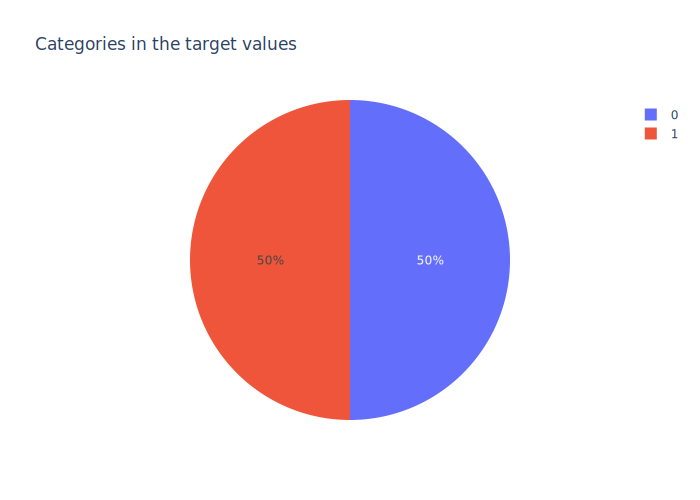

This class doesn't look like imbalanced, please make sure looking the graph


In [23]:
is_imba(y)

So we took a lot of the data out but preserved all the fraud class (class=1), Let us use again our trusty pipeline!

In [24]:
def fit_model(X,y,X_test=False,
             cv=3,n_jobs=-1,scoring='accuracy',
             max_depth=10,n_estimators=344,n_neighbors=5,thr=0.5,sample_weight=None ):

    # We are gonna use a cross validation now
    
    """
    best model so far is: 
    {'model__max_depth': 10,
    'model__n_estimators': 344,
    'preprocessor__numerical_transformer__imputer__n_neighbors': 5}
    
    
    """

    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]

    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=n_neighbors))
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators ,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
   
    # this fit the pipeline to a specific model, giving an specific traning set (notice that the cross-val does not do that)
   
    pipe.fit(X,y,model__sample_weight=sample_weight)
    y_pred = pipe.predict(X_test)
    y_proba = None
    try:
        # X_test = False this will not run and it is ok
        y_proba = pipe.predict_proba(X_test)
    except:
        pass
    
    return y_proba, y_pred

In [25]:
y_proba, y_pred = fit_model(X,y,X_test=X_test)

f1: 0.12108262108262108
accuracy: 0.9783364348161933


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

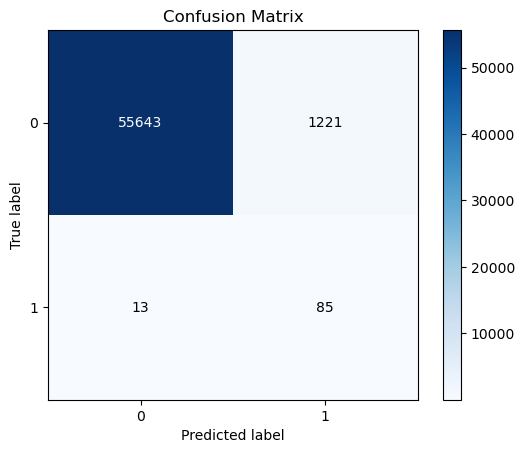

In [29]:
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

So we decrease the overall accuracy and f1-score, but notice we predicted more fraud (class=1) than before. Even though we predicted more fraud than before more fraud prediction are indeed normal transaction. Let us try to improve it!